In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from IPython.display import Image

import astropy.constants as cs
import os

import astropy.io.fits as pyfits

import hstscan.pipeline as pipe
import hstscan.reduction as r
import hstscan.data as data
from hstscan.data import view_frame_image as view
import tqdm
import glob
import csv

# Setup for light-curve reduction

### 1) Download data
https://archive.stsci.edu/hst/search.php

\_ima files for all data

\_drz and \_flt files for the direct images (taken with Filters instead of Grism)

In [2]:
# data_dir: directory where the _ima files are stored
Dir = '/Users/bob/Documents/PhD/hstscan/hstscan/example/'
data_dir = Dir + 'data/'
output_dir = Dir + 'output/'

conf_file_red = Dir + 'transmission_reduction.conf'
conf_file_ext = Dir + 'transmission_extraction.conf'

#Define a table of custom knots. A row for each subexposure. 
#If you haven't created this yet, please run the remainder of this code to find out the best knots.
#To do this, you need to set custom_knots_F=None, custom_knots_R=None in all extraction functions.
#Then create your own table with *interior* knots in ascending order
custom_knots = []
import csv
custom_knots = []
if os.path.isfile(Dir + 'custom_knots.csv'):
    with open(Dir + 'custom_knots.csv', 'rb') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',')
        for row in spamreader:
            row = np.array(row)
            custom_knots.append(row[row != ''].astype(float))
    noknots=False
else:
    noknots=True

### 2) Produce visit information lists

In [3]:
# prop_str: first 4 characters of the files' names (proposal ID string)
data.make_input_image_lists(data_dir=data_dir, prop_str='ibh7')

['26']
Starting visit 26
ibh726meq_ima.fits
Completed file 1 for visit 26
ibh726mdq_ima.fits
Completed file 2 for visit 26
ibh726miq_ima.fits
Completed file 3 for visit 26
#####################
Visit 26 completed.
#####################


At this point it makes sense to re-name the visit files to more appropriate names, e.g. visit_26.lis -> transit.lis. This is not necessary, though.

The above code only needs to be run once after you've downloaded the data. So, you may disable the above code, as it's kinda slow.

### 3) Define a list of reference files

These reference files are used to calculate the absolute wavelength solution. They are typically the first grism exposures of each visit. Each visit should have at least one reference exposure.

In [4]:
ref_Images = ['ibh726meq_ima.fits']

### 4) Fit direct image positions to produce position catalogues

Only a single star should be fully inside the second image.

Writing to: /Users/bob/Documents/PhD/hstscan/hstscan/example/data/ibh726mdq_flt_1.cat
Shape (242, 271)


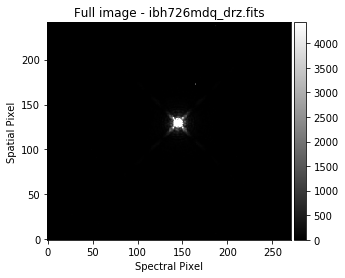

Name          Value      Min      Max   Stderr     Vary     Expr Brute_Step
amplitude  5.125e+05        0      inf    419.6     True     None     None
x_mean          145        0      242 0.0009071     True     None     None
x_stddev      1.107        0      inf 0.0009058     True     None     None
y_mean        129.2        0      242 0.0008868     True     None     None
y_stddev      1.082        0      inf 0.0008862     True     None     None


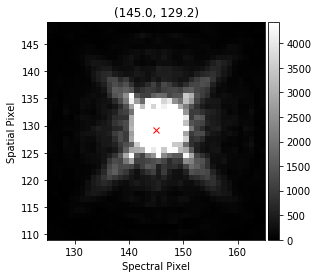

In [5]:
reload(pipe)
# gridsize: coarseness of initial search for source
# nstars: number of stars for which positions should be measured (in order of brightness)
# use_ima: use _ima files instead of _flt in case of problems
pipe.create_orbit_cats_gauss(data_dir=data_dir, conf_file=conf_file_red, gridsize=20, use_ima=False, nstars=1)

Now have everything you need to reduce an exposure and produce spectra

# Config file parameters

## Red

### Parameters to define yourself
 - source_dir
 - save_dir
 - scan_rate
 - bg_x,y,w,h
 - flat_file_g141
 - conf_file_g141
 - ref_exp
 - stellar_spectrum (PHOENIX model. TBF @ http://phoenix.astro.physik.uni-goettingen.de/?page_id=15) from https://arxiv.org/pdf/1303.5632.pdf
     You could also use a .txt file with one column of wavelengths in Angstrom and one of Flux in erg/s/cm^2/A. This file should have a one-line-header. This is useful if you want to use an ATLAS spectrum.
 - stellar_wavelengths (file with the PHOENIX model wavelength definition)
 - HST_EPH_FILE The file with the ephemerides of HST. Downloadable from https://ssd.jpl.nasa.gov/horizons.cgi#top. See the example below

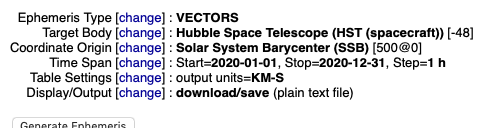

In [6]:
Image(filename = "ephemeris_example.png", width = 600, height = 300)

### Leave
These you are unlikely to want to change, although their effects are important
 - scanned = True
 - units = True
 - read_noise = 20
 - skip_start = 1
 - skip_end = 0
 - bg = True
 - bg_area = True
 - cr_local = True
 - dispersion = True
 - flat_field = True
 - ff_min = 0.5
 - contam_thresh = 0.01
 - nysig = 5
 - abs_wshift = True   #Whether to calculate the wavelength solution from the grism transmission fct.
 - peak = False
 - zeroth_ord_wshift = False
 - wshift_from_postarg = False
 - stel_spec_gauss_kern_sig = 1
 - tai_utc_file
 
### Cosmic Rays
You may want to experiment with cosmic ray removal parameters, can turn off cosmic ray removal for a first run
 - cr_tolx = 5 (try to lower without removing spectrum)
 - cr_tolx = 5
 - cr_x,y (consider tweaking if CR removal too agressive/weak)
 - cr_thresh = 50 (can raise) (determines the flux level threshold for cosmic ray detection)

### Data quality flags
Lookup flags in data handbook. 4: Bad detector pixel, 32: IR unstable pixel.

Leave as is unless there are problems.
 - dq_flags = [4,32]
 - dq_replace = None
 - dq_mean_width = 1
 
### Wavelength Solution
For now, disable the Tsiaras wavelength solution and use the simple interpolation.
May want to tweak drift_width and rowtol, parameters for smoothing the drift within an exposure.

E.g. define
 - tsiaras = False

We use the Wilkins et al. 2014 wavelength solution
 - disp_coef = 'wilkins'


### Plots
Leave on while still tweaking
 - debug = True
 - pdf = True
 - logger = True
 - bg_plot = True
 - cr_plot = True
 
### Tweak to position extraction box
Depending on the observations, need to account/remove different effects to center the spectrum in the extraction box. Have not figured out a universal solution.

 - remove_scan
 - postarg_yguess
 - default_scan
 
 
### Ignore
These are either no longer used, in development, or were for specific data sets/modes.
 - system
 - nlincorr
 - psf_h (these are for bg removal with masks)
 - mask_h
 - psf_w
 - n_masks
 - neg_masks
 - cr_replace
 - cr_master
 - cr_mname
 - ref_wv0
 - ref_wv1
 - pre_shift_ff
 - ext_wshift
 - grid_y
 - grid_lam
 - two_scans 
 - interp_kind
 - object_ind

## Ext

### Parameters to define yourself
 - save_dir
 - box_h (ensure large enough to capture whole spectrum)
 - ref_exp
 
### Plots
- debug = True
- logger = True
- pdf = True
- oe_debug = False (its very slow, turn on only if focusing on optimal extraction)
- show_knots = True

### Leave
 - save_extension = '_spec.txt'
 - calc_var = True
 - extraction_box = True
 - shift_spectra = True
 - shift_wv0 = 1.14
 - shift_wv1 = 1.6
 - peak = False
 - opt_ext = True
 - drift_wshift = False (if changed to True, opt_ext should be False)
 
### Tweak (if drift_wshift is enabled)
 - drift_width = 4
 - drift_rowtol = 1.1
 
### Optimal Extraction

#### Tweak

- order (integer)(don't pick order=2, 1 and 3 are most stable)
- outliers_to_average  #substitutes outliers/DQ/CRs with the average of the surrounding pixels if possible

#### Leave
- fit_tol
- step (only works if func_type is not spline, custom_spline or split_spline and method is lsq
- k_col/row
- s = 0
- v_0 = 400
- q = 1
- s_clip = None
- s_cosmic = None
- func_type = 'spline'
- method = 'lsq'
- remove_bg = True
- object_ind = 0
- fit_dq = False
- wshift_sub_exps = True
- wstretch_sub_exps = True (especially recommended for forward + reverse scanned data)
- no_interp = False  #Cannot be true if wshift_sub_exps is enabled.
 
### Ignore
- save_sub
- mask_neg
- ignore_blobx
- blob_thresh
- skip_fit
- top_half
- slopefactor

# Run data reduction on one exposure

Check 

 - Do the subexposures agree, smoothly across the whole wavelength range?
 
 - How many optimal extraction fits fail near the peak of the spectrum?
 
 - Check the fits, are they overfitting or underfitting clearly? Safer to overfit.

In [7]:
#Define the center pixel of each subexposure in y-direction. You can also run with the custom_knots=None argument to find out what these should be.
ypix_F = [216, 163, 108]
ypix_R = [216, 163, 108]

########################################
############Started Reduction##########
########################################
Data reduction pipeline performed on exposure /Users/bob/Documents/PhD/hstscan/hstscan/example/data/ibh726meq_ima.fits
For configuration, see pipeline conf file: /Users/bob/Documents/PhD/hstscan/hstscan/example/transmission_reduction.conf


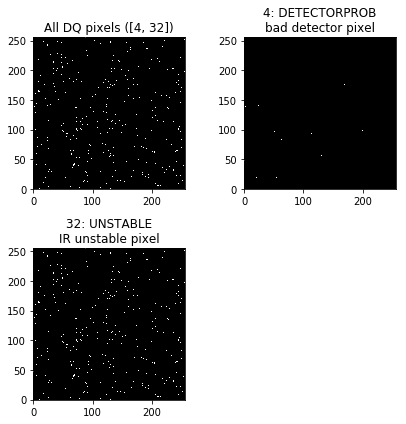

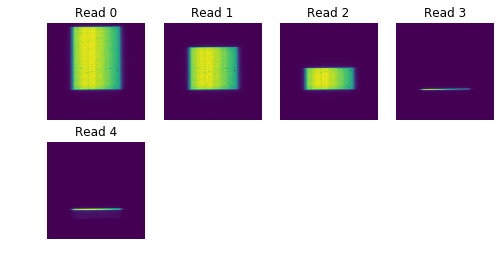

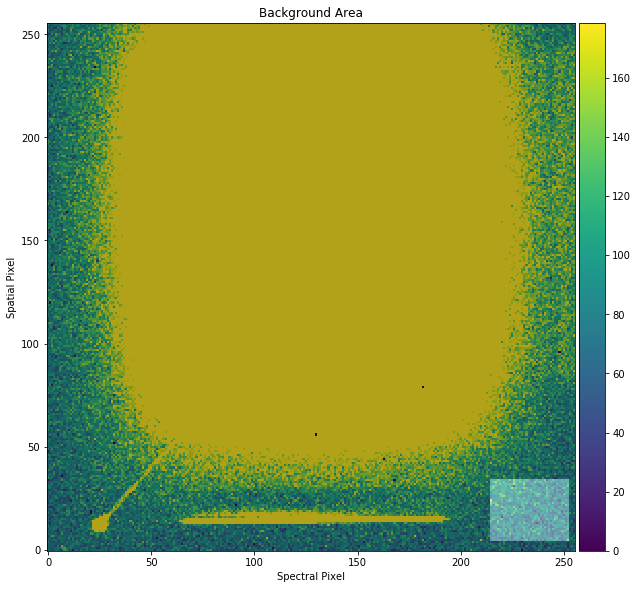

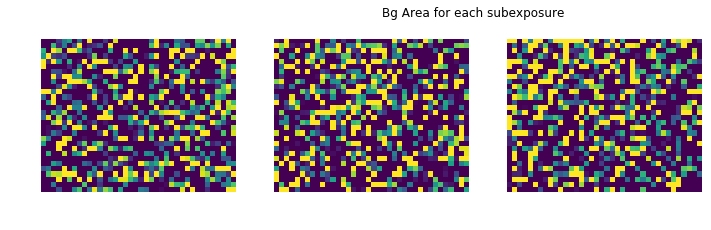

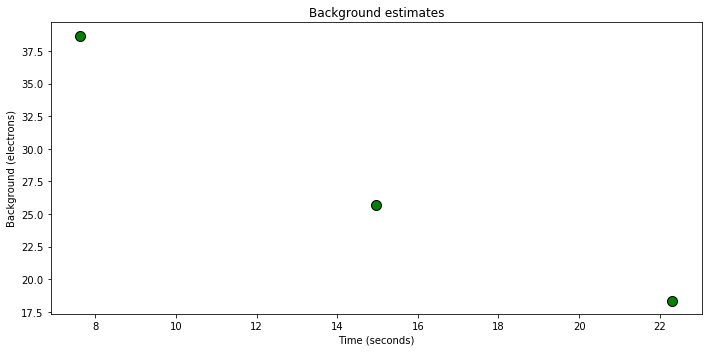

Forward scan
Catalogue used: /Users/bob/Documents/PhD/hstscan/hstscan/example/data/ibh726mdq_flt_1.cat
Direct Image name: ibh726mdq
catalogue /Users/bob/Documents/PhD/hstscan/hstscan/example/data/ibh726mdq_flt_1.cat
Catalogue file: ibh726mdq_ima.fits
########################
Direct image location of (145.027019491,129.205912781)


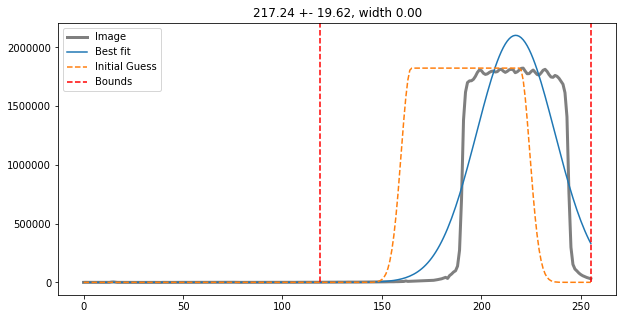

using a PHOENIX stellar model


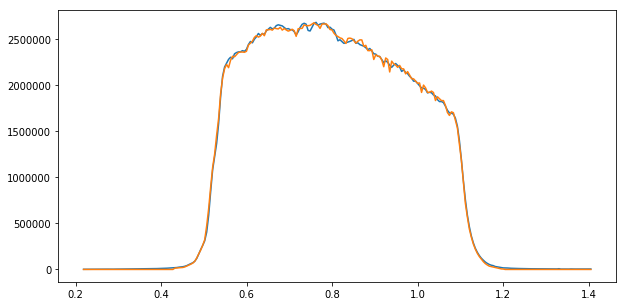

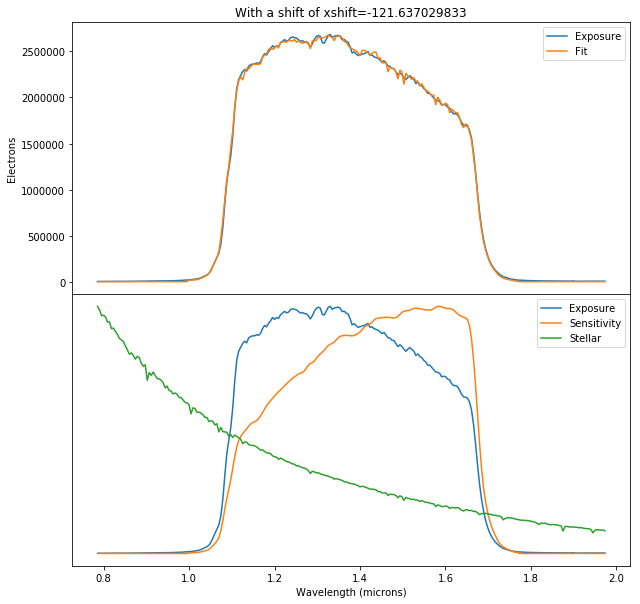

Applied an xshift of -121.637029833 pix from a comparison to a stellar spectrum
Initial xpix is 23 and shift_in_x: -121.637029833
applying postarg offset to yguess, 147.60 pix


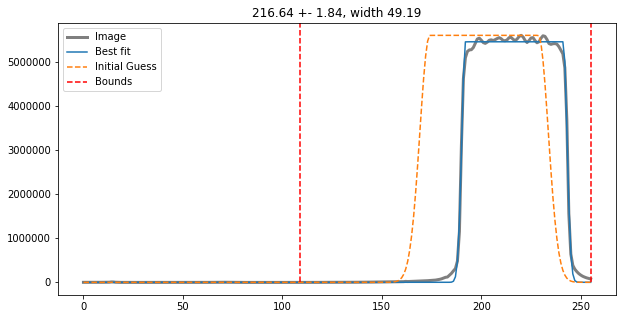

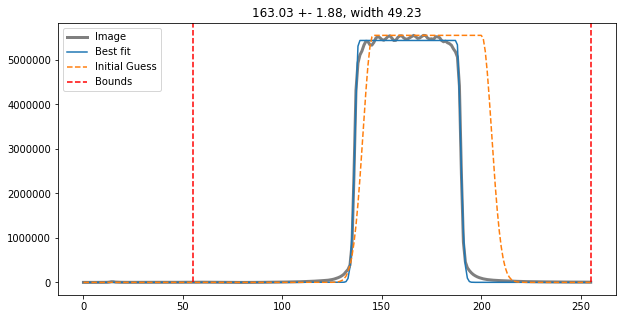

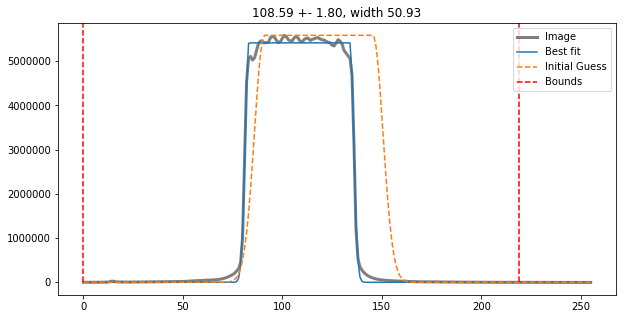

The final xpix is 23
applying postarg offset to yguess, 147.60 pix


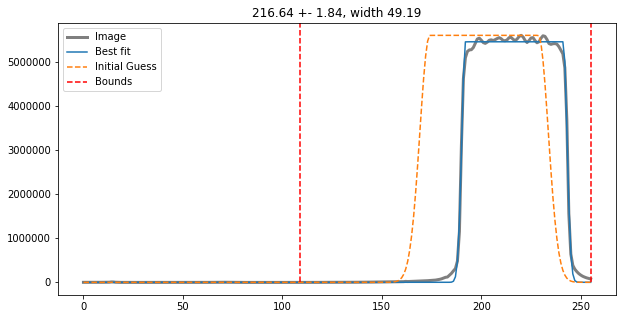

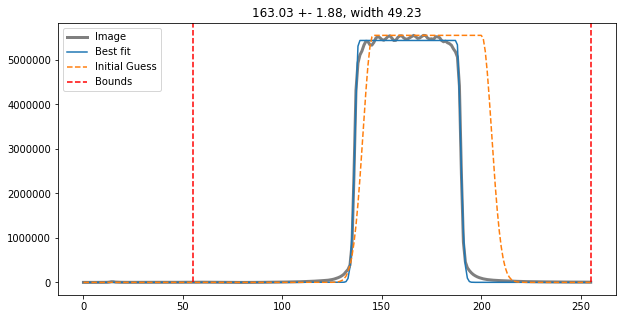

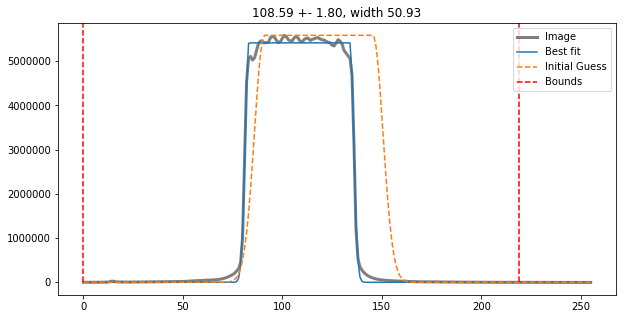

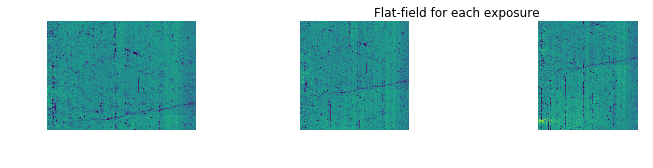

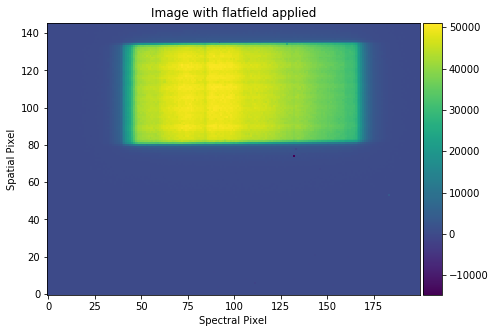

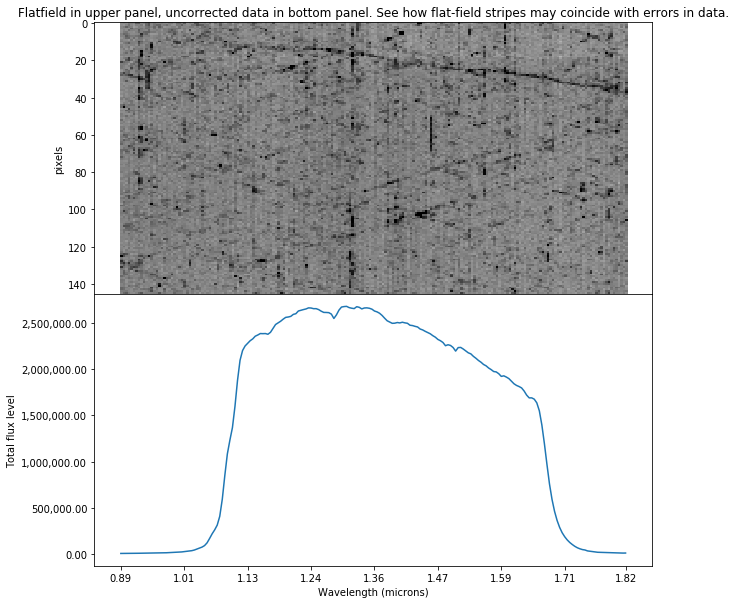

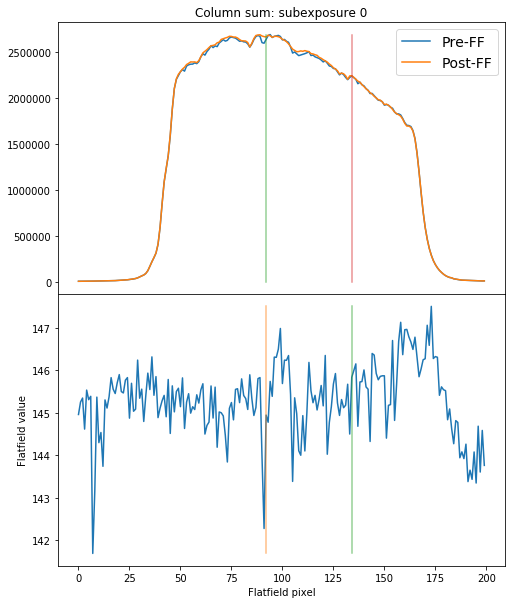

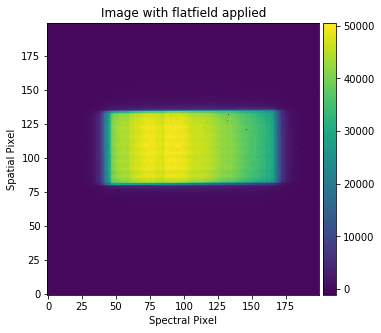

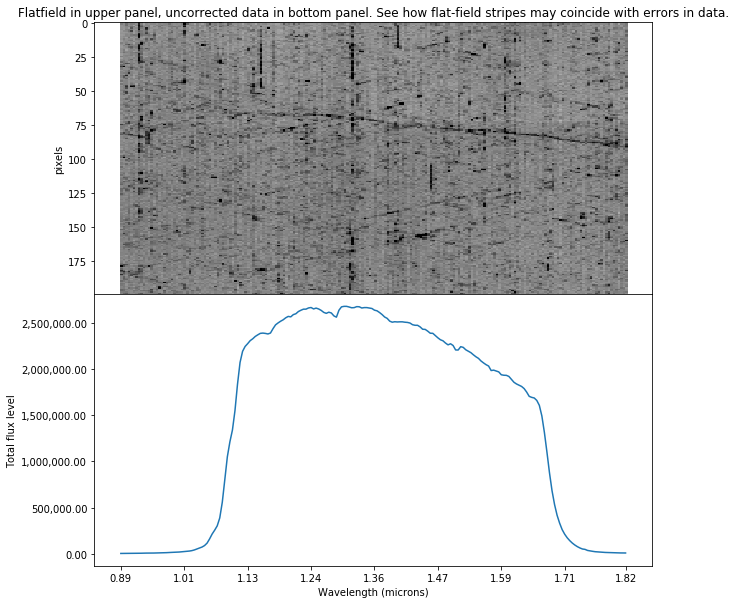

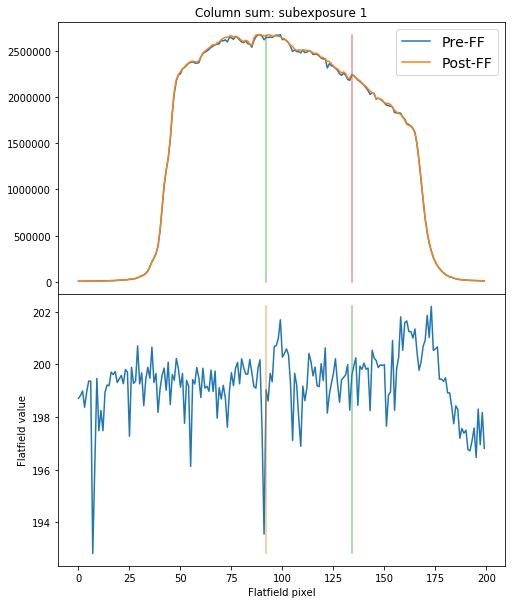

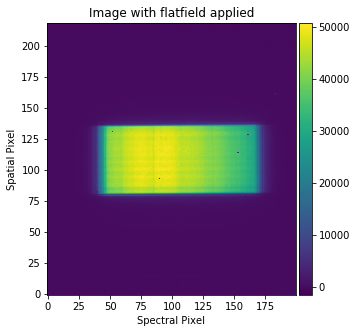

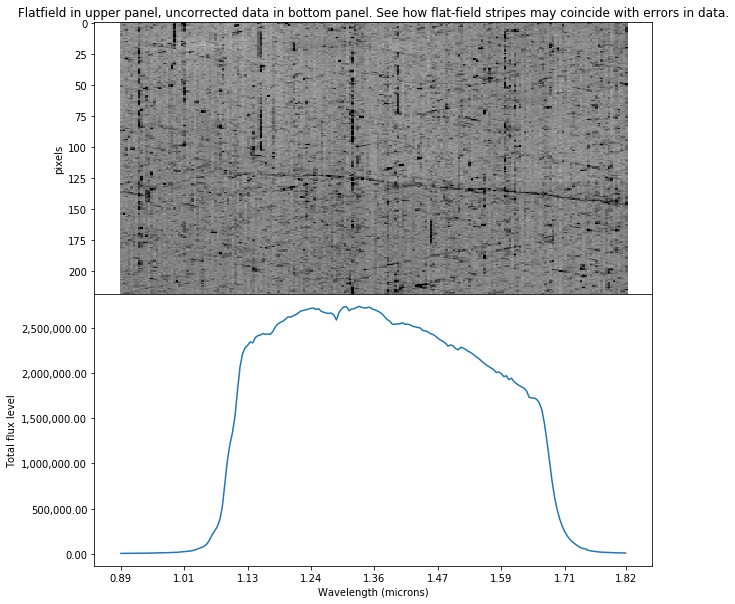

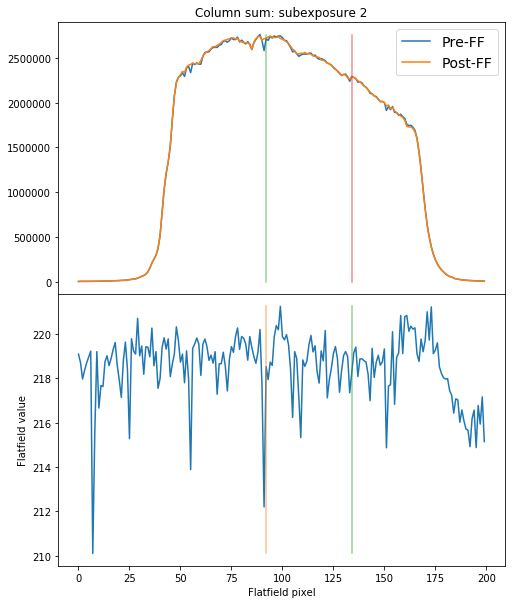

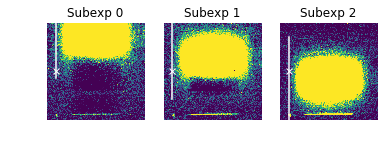

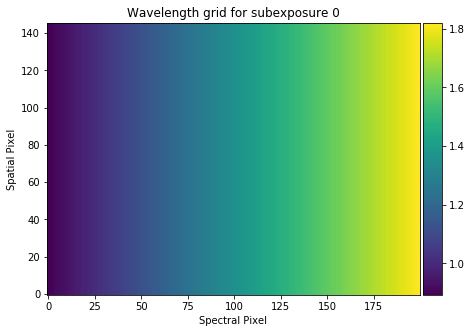

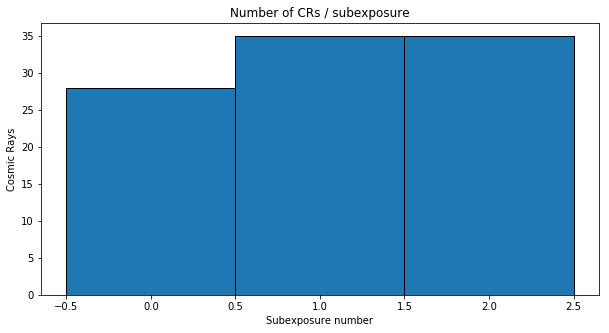

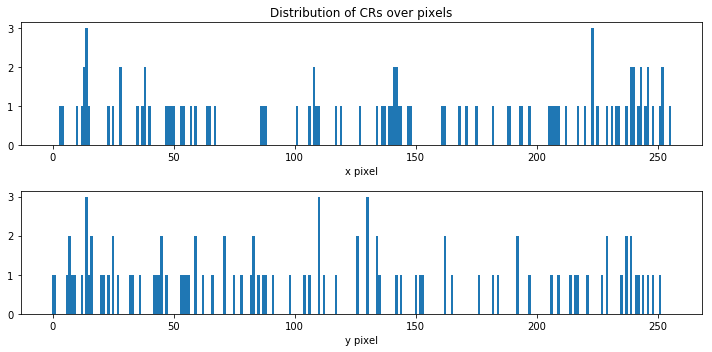

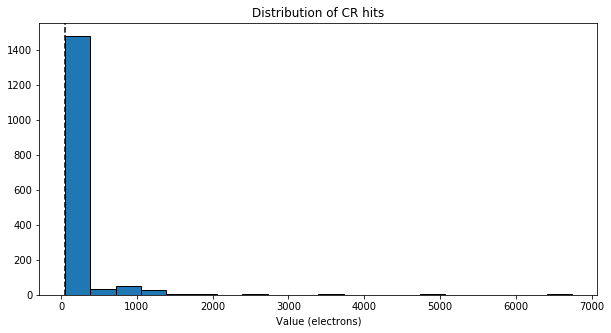

This should have a median energy of 1000 electrons
Nr. of DQs, CRs and CRs minus DQs 2388, 98 and 98
Percentage of pixels affected by CRs:0.149536132812 %, which should be ~0.0867893833333% if there is no South Atlantic anomaly.


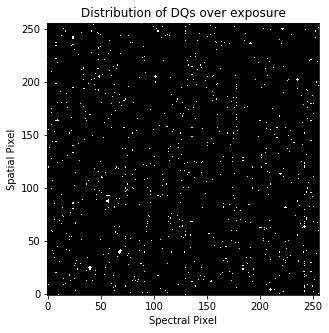

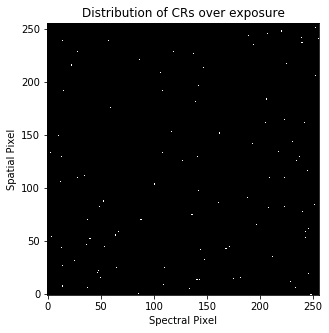

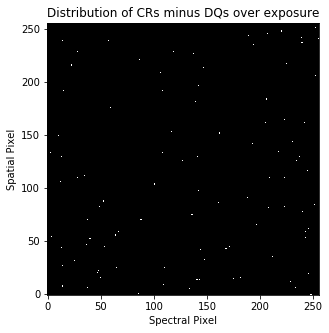

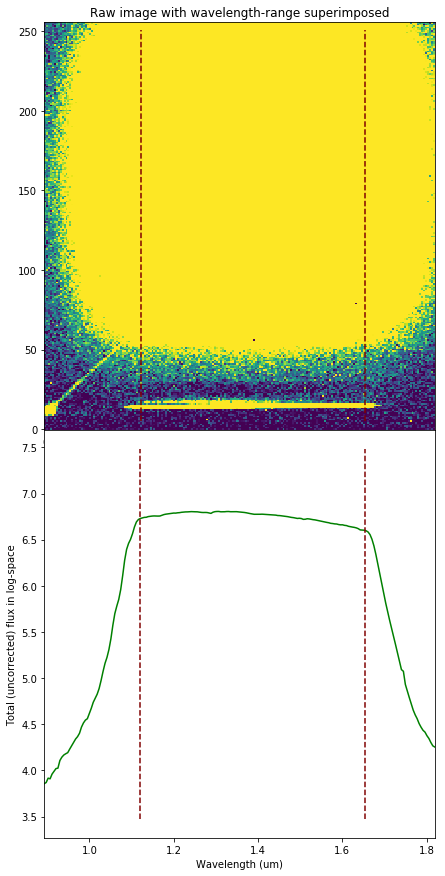

Saving reduced file to /Users/bob/Documents/PhD/hstscan/hstscan/example/output/
Saving reduced exposure to /Users/bob/Documents/PhD/hstscan/hstscan/example/output/ibh726meq_red.fits...
Reduction took 9.28s
########################################
###########Finished Reduction###########
########################################
########################################
############Started Extraction##########
########################################
Spectral extraction pipeline performed on exposure /Users/bob/Documents/PhD/hstscan/hstscan/example/data/ibh726meq_ima.fits
For configuration, see conf file: /Users/bob/Documents/PhD/hstscan/hstscan/example/transmission_extraction.conf
Forward scan
Extracting from subexposure 1
Extracting spectrum with a 107 high extraction box
nr. of CRs 824
Spectrum located at pixel 123 in spatial direction
subexp 216.64335974856073 [216, 163, 108]
ypix is 216 for exposure 0


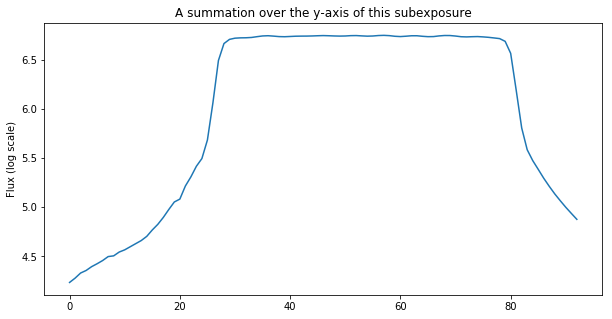

The difference between the two edges (for a 5-pixel bin for all subexps is): 6941.34765625
This value may not be larger than  6298.882863915897  or else you'll have variations induced by the moving of this subexposure on the y-axis.
Using flux for variance estimate
Extracting spectrum with optimal extraction...
2668850.9643399804 pl 2668850.9643399804 52.807545
Knots estimated by pipeline are: [ 0.  7. 14. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 34. 40. 47. 53.
 60. 66. 70. 73. 76. 77. 78. 79. 80. 81. 82. 83. 84. 92.]


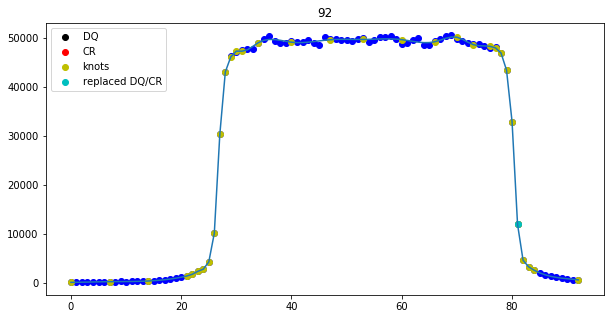

2633010.6341989157 pl 2633010.6341989157 52.601894
Knots estimated by pipeline are: [ 0.  7. 14. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 34. 40. 47. 53.
 60. 66. 70. 73. 76. 77. 78. 79. 80. 81. 82. 83. 84. 92.]


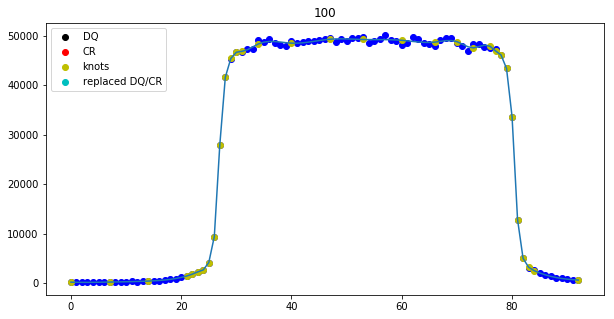

2624310.6922645774 pl 2624310.6922645774 52.421673
Knots estimated by pipeline are: [ 0.  7. 14. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 34. 40. 47. 53.
 60. 66. 70. 73. 76. 77. 78. 79. 80. 81. 82. 83. 84. 92.]


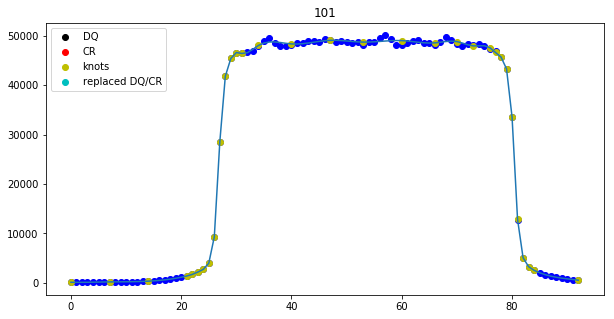

199 successes out of 200 total fits
Optimal extraction fitting failed for columns: [0]
Clipped 0 cosmic rays in OE
Extracting from subexposure 2
nr. of CRs 859
Spectrum located at pixel 123 in spatial direction
subexp 163.02611334604822 [216, 163, 108]
ypix is 163 for exposure 1


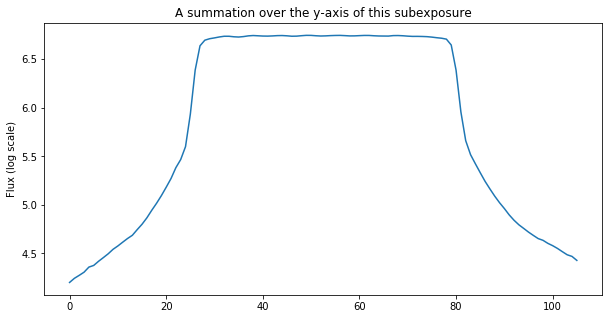

The difference between the two edges (for a 5-pixel bin for all subexps is): 1357.342578125
This value may not be larger than  6308.245271071822  or else you'll have variations induced by the moving of this subexposure on the y-axis.
Extracting spectrum with optimal extraction...
2663569.671548585 pl 2663569.671548585 52.728844
Knots estimated by pipeline are: [  0.   7.  14.  21.  22.  23.  24.  25.  26.  27.  28.  29.  30.  31.
  34.  40.  47.  53.  60.  66.  70.  73.  75.  76.  77.  79.  80.  81.
  82.  83.  84.  86.  92. 105.]


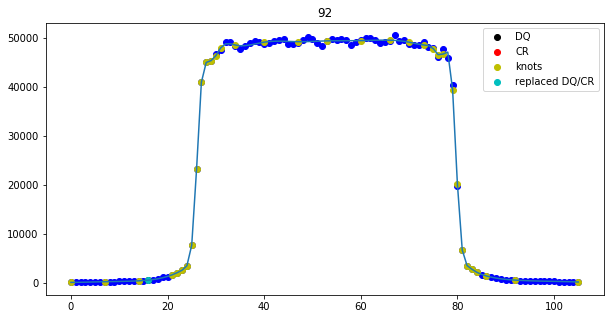

2635327.599613664 pl 2635327.599613664 52.74246
Knots estimated by pipeline are: [  0.   7.  14.  21.  22.  23.  24.  25.  26.  27.  28.  29.  30.  31.
  34.  40.  47.  53.  60.  66.  70.  73.  75.  76.  77.  79.  80.  81.
  82.  83.  84.  86.  92. 105.]


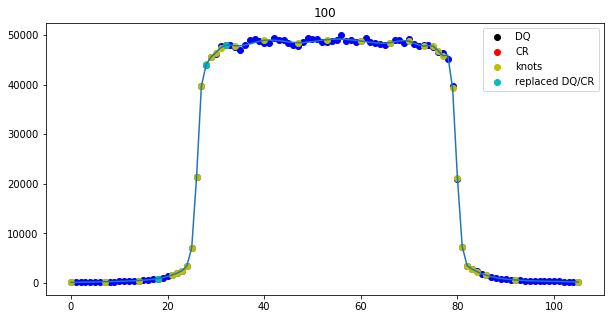

2629278.981612865 pl 2629278.981612865 53.18307
Knots estimated by pipeline are: [  0.   7.  14.  21.  22.  23.  24.  25.  26.  27.  28.  29.  30.  31.
  34.  40.  47.  53.  60.  66.  70.  73.  75.  76.  77.  79.  80.  81.
  82.  83.  84.  86.  92. 105.]


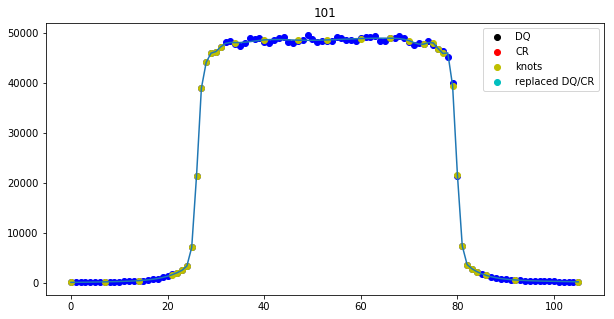

196 successes out of 200 total fits
Optimal extraction fitting failed for columns: [0, 1, 2, 3]
Clipped 0 cosmic rays in OE
Extracting from subexposure 3
nr. of CRs 866
Spectrum located at pixel 123 in spatial direction
subexp 108.58583331525763 [216, 163, 108]
ypix is 108 for exposure 2


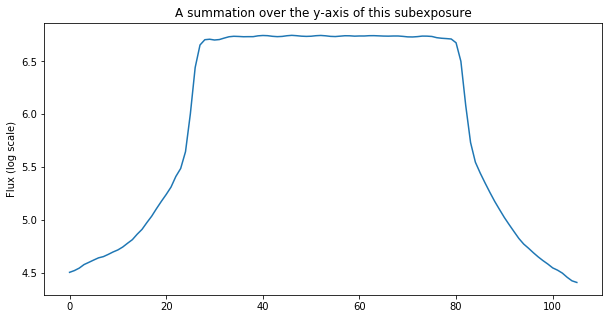

The difference between the two edges (for a 5-pixel bin for all subexps is): 752.464453125
This value may not be larger than  6372.9990428368965  or else you'll have variations induced by the moving of this subexposure on the y-axis.
Extracting spectrum with optimal extraction...
2709084.135951804 pl 2709084.135951804 54.02664
Knots estimated by pipeline are: [  0.   7.  14.  21.  22.  23.  24.  25.  26.  27.  28.  29.  30.  31.
  34.  40.  47.  53.  60.  66.  70.  73.  75.  76.  77.  79.  80.  81.
  82.  83.  84.  86.  92. 105.]


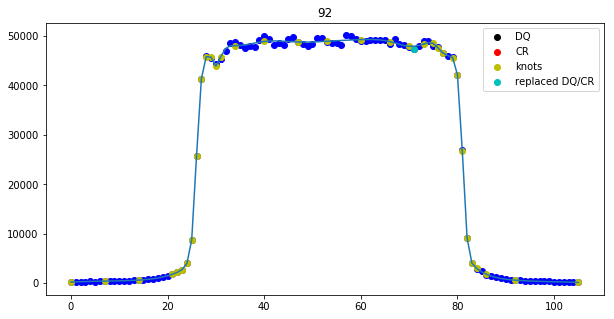

2698954.8503580275 pl 2698954.8503580275 54.57026
Knots estimated by pipeline are: [  0.   7.  14.  21.  22.  23.  24.  25.  26.  27.  28.  29.  30.  31.
  34.  40.  47.  53.  60.  66.  70.  73.  75.  76.  77.  79.  80.  81.
  82.  83.  84.  86.  92. 105.]


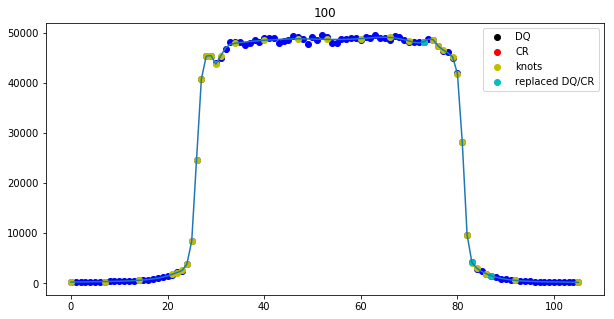

2689018.531961163 pl 2689018.531961163 54.521793
Knots estimated by pipeline are: [  0.   7.  14.  21.  22.  23.  24.  25.  26.  27.  28.  29.  30.  31.
  34.  40.  47.  53.  60.  66.  70.  73.  75.  76.  77.  79.  80.  81.
  82.  83.  84.  86.  92. 105.]


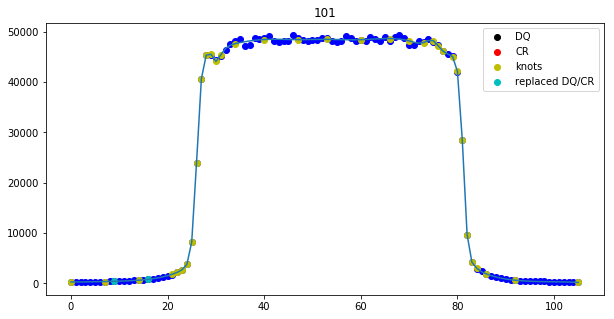

191 successes out of 200 total fits
Optimal extraction fitting failed for columns: [7, 8]
Clipped 0 cosmic rays in OE


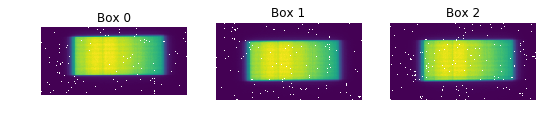

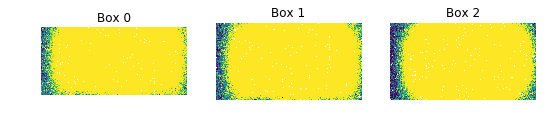

Shifted subexposure nr. 1 with -0.463680899843 pixels and shrunk 0.279444859358 percent.
Shifted subexposure nr. 2 with -0.88384205718 pixels and shrunk 0.546825803702 percent.


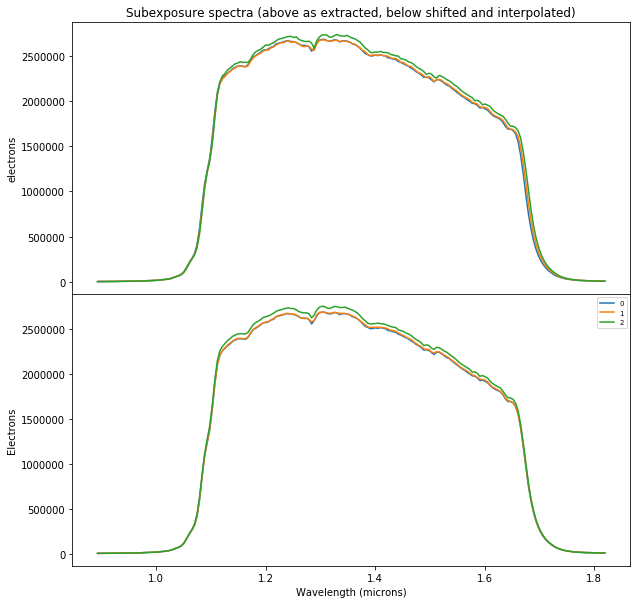

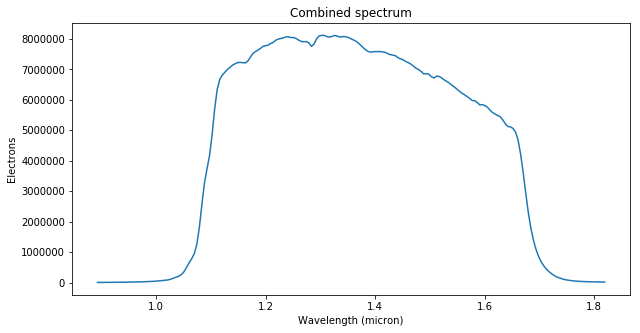

Saving spectrum to /Users/bob/Documents/PhD/hstscan/hstscan/example/output/ibh726meq_spec.txt
Saving subexposure spectra to /Users/bob/Documents/PhD/hstscan/hstscan/example/output/ibh726meq_subs_spec.txt
Extraction took 2.38s
########################################
###########Finished Extraction##########
########################################


In [9]:
reload(pipe)
fname = 'ibh726meq_ima.fits'
visit = 1

if visit == 1:
    Bg_x, Bg_y, Bg_w, Bg_h = (215, 5, 38, 30)
    Ref_exp = ref_Images[0].split('_ima.fits')[0]
    
if fname == Ref_exp + '_ima.fits':
    Save_sub = True
else:
    Save_sub = False

exp = pipe.reduce_exposure(fname, pdf=False, logger=False, debug=True,
                           bg_x = Bg_x, bg_y = Bg_y, bg_w = Bg_w, bg_h = Bg_h,
                           cr_tolx=6, cr_toly=6, cr_thresh=50,
                           ref_exp = Ref_exp,
                           conf_file=conf_file_red, \
                           source_dir=data_dir, write = True)
if noknots:
    exp_spectrum, variance, interp_spectra, variances = \
                    pipe.extract_spectra(exp, pdf=False, logger=False, debug=True,
                    conf_file=conf_file_ext, ref_exp=Ref_exp,
                    save_dir=output_dir, save_sub=Save_sub)
else:
        exp_spectrum, variance, interp_spectra, variances = \
                    pipe.extract_spectra(exp, pdf=False, logger=False, debug=True,
                    conf_file=conf_file_ext, ref_exp=Ref_exp, ypix_F=ypix_F, ypix_R=ypix_R,
                    custom_knots_F=custom_knots, custom_knots_R=custom_knots[::-1],
                    save_dir=output_dir, save_sub=Save_sub, show_knots=True)

# Taking multiple images...

In [23]:
Images = glob.glob(data_dir + '*_ima.fits')
Images = np.sort([image.replace(data_dir, '') for image in Images])
Images = [str(I) for I in Images]


In [24]:
Direct_images = []
with open(data_dir + 'visit_driz.lis') as g:
    for line in g:
        Direct_images.append(line.replace('\n',''))
for image in Direct_images:
    imagename = image.replace('_drz', '_ima')
    Images.remove(imagename)

In [25]:
Images

['ibh726meq_ima.fits',
 'ibh726mfq_ima.fits',
 'ibh726mgq_ima.fits',
 'ibh726mhq_ima.fits',
 'ibh726miq_ima.fits',
 'ibh726mjq_ima.fits',
 'ibh726mkq_ima.fits',
 'ibh726mlq_ima.fits',
 'ibh726mmq_ima.fits',
 'ibh726mnq_ima.fits',
 'ibh726mrq_ima.fits',
 'ibh726msq_ima.fits',
 'ibh726mtq_ima.fits',
 'ibh726muq_ima.fits',
 'ibh726mvq_ima.fits',
 'ibh726mwq_ima.fits',
 'ibh726mxq_ima.fits',
 'ibh726myq_ima.fits',
 'ibh726n0q_ima.fits',
 'ibh726n1q_ima.fits',
 'ibh726n2q_ima.fits',
 'ibh726n6q_ima.fits',
 'ibh726n7q_ima.fits',
 'ibh726n8q_ima.fits',
 'ibh726n9q_ima.fits',
 'ibh726naq_ima.fits',
 'ibh726nbq_ima.fits',
 'ibh726ncq_ima.fits',
 'ibh726ndq_ima.fits',
 'ibh726neq_ima.fits',
 'ibh726nfq_ima.fits',
 'ibh726ngq_ima.fits',
 'ibh726nhq_ima.fits',
 'ibh726niq_ima.fits',
 'ibh726nkq_ima.fits',
 'ibh726nlq_ima.fits',
 'ibh726nmq_ima.fits',
 'ibh726nnq_ima.fits',
 'ibh726nrq_ima.fits',
 'ibh726nsq_ima.fits',
 'ibh726ntq_ima.fits',
 'ibh726nuq_ima.fits',
 'ibh726nvq_ima.fits',
 'ibh726nwq

First do the reference exposures. They should be the first spectrum of each visit.

########################################
############Started Reduction##########
########################################
Data reduction pipeline performed on exposure /Users/bob/Documents/PhD/HD209458/Transmission/ibh726meq_ima.fits
For configuration, see pipeline conf file: /Users/bob/Documents/PhD/HD209458/transmission_reduction.conf


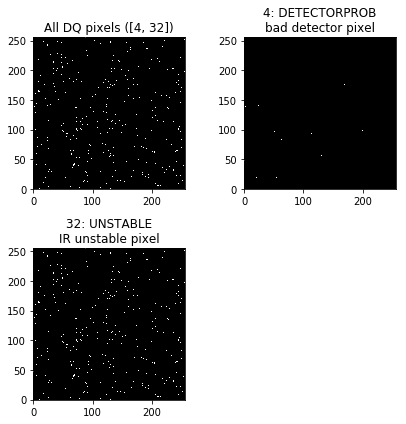

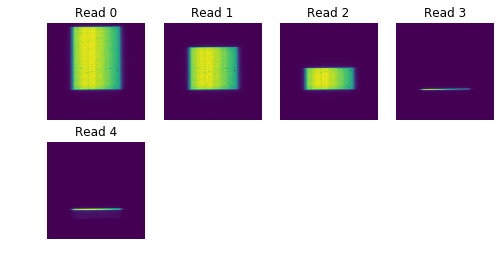

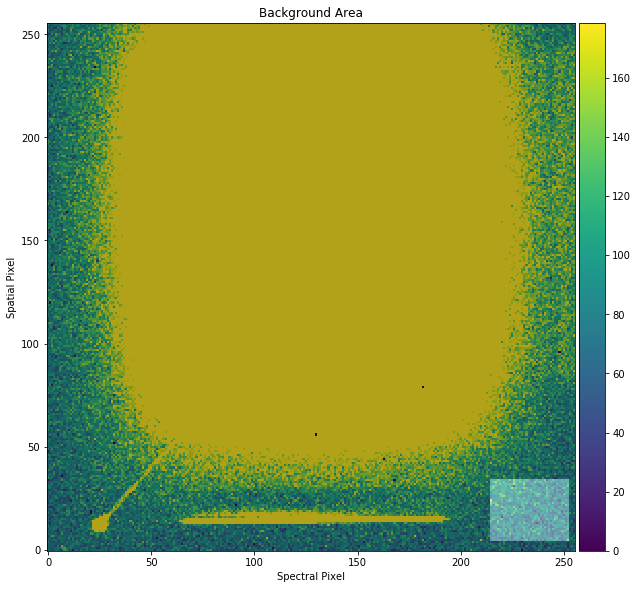

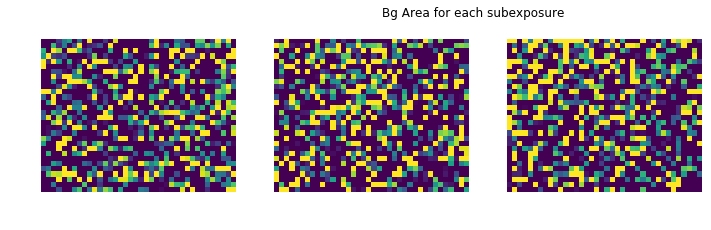

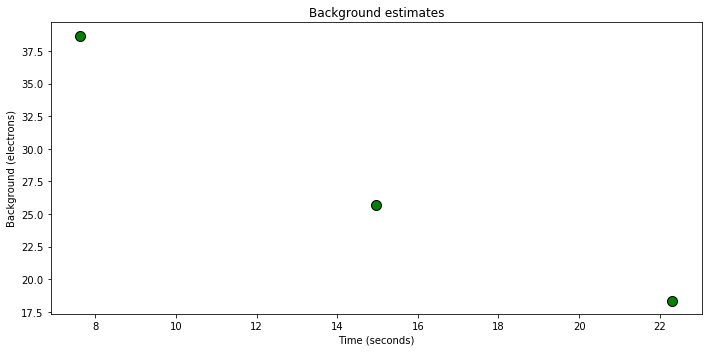

Forward scan
Catalogue used: /Users/bob/Documents/PhD/HD209458/Transmission/ibh726mdq_flt_1.cat
Direct Image name: ibh726mdq
catalogue /Users/bob/Documents/PhD/HD209458/Transmission/ibh726mdq_flt_1.cat
Catalogue file: ibh726mdq_ima.fits
########################
Direct image location of (145.027019491,129.205912781)


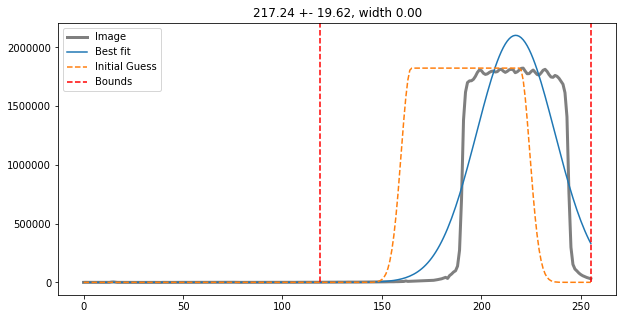

using a PHOENIX stellar model


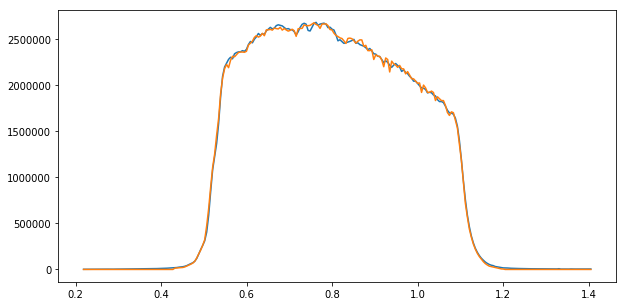

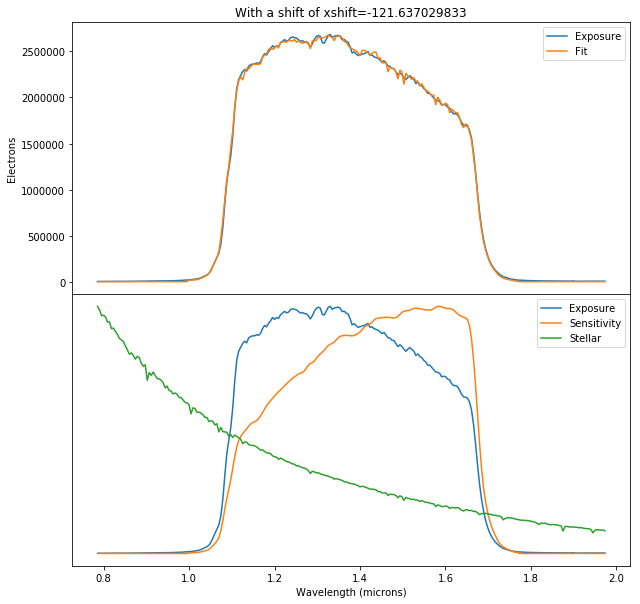

Applied an xshift of -121.637029833 pix from a comparison to a stellar spectrum
Initial xpix is 23 and shift_in_x: -121.637029833
applying postarg offset to yguess, 147.60 pix


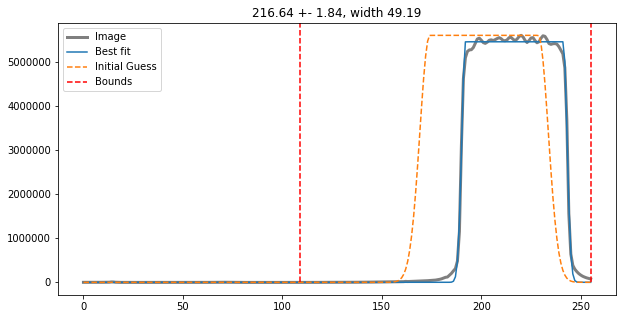

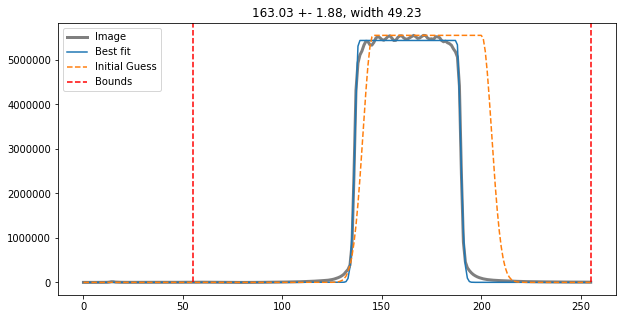

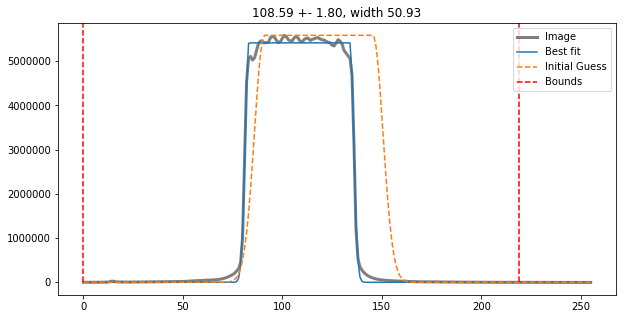

The final xpix is 23
applying postarg offset to yguess, 147.60 pix


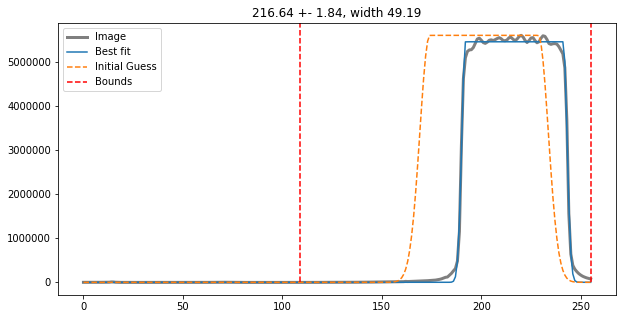

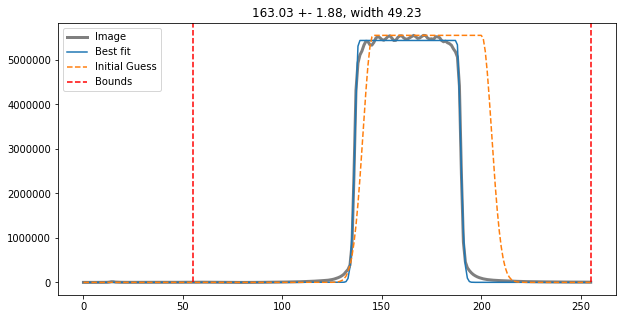

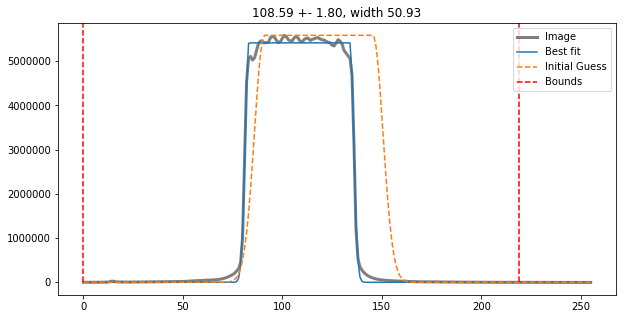

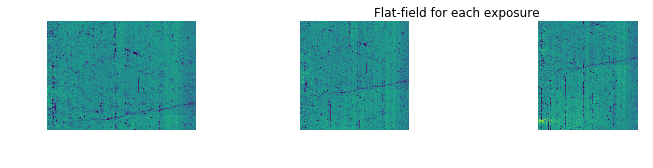

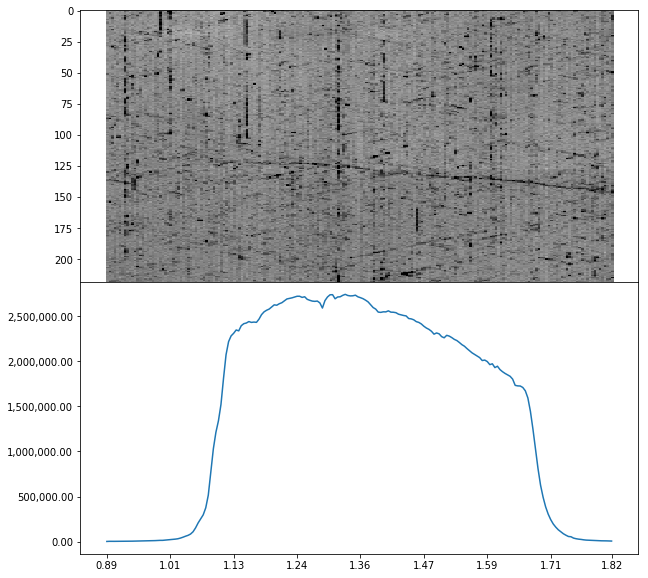

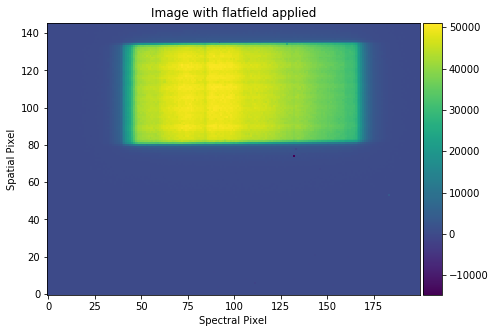

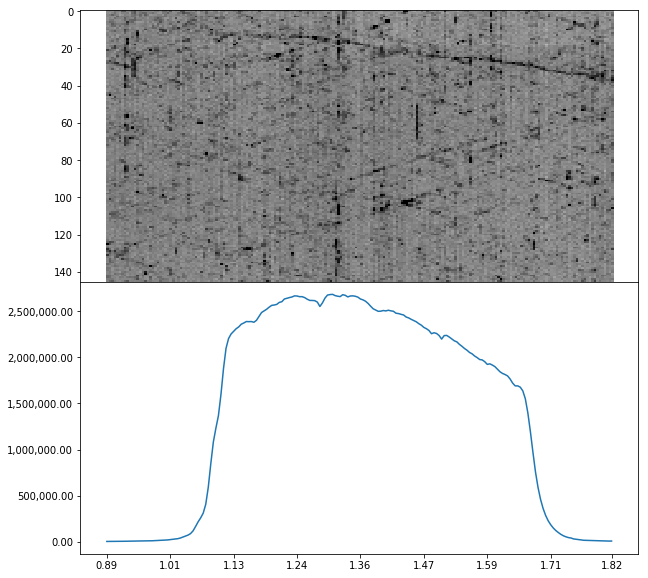

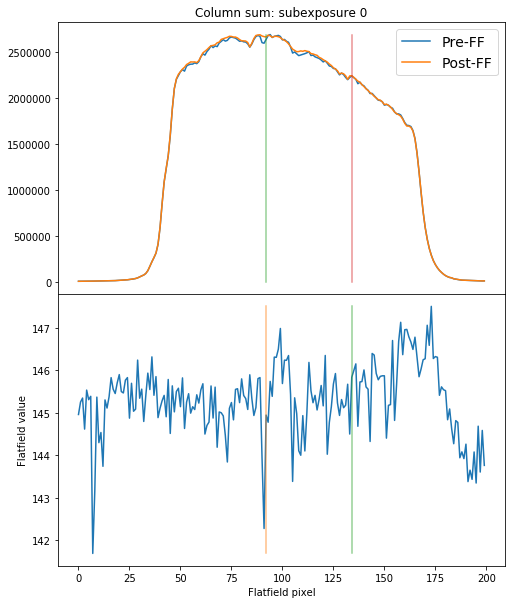

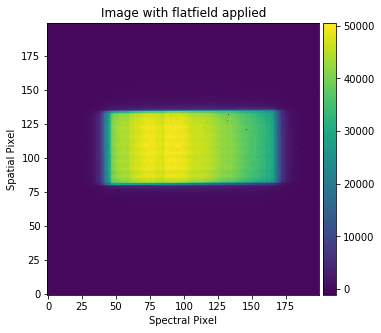

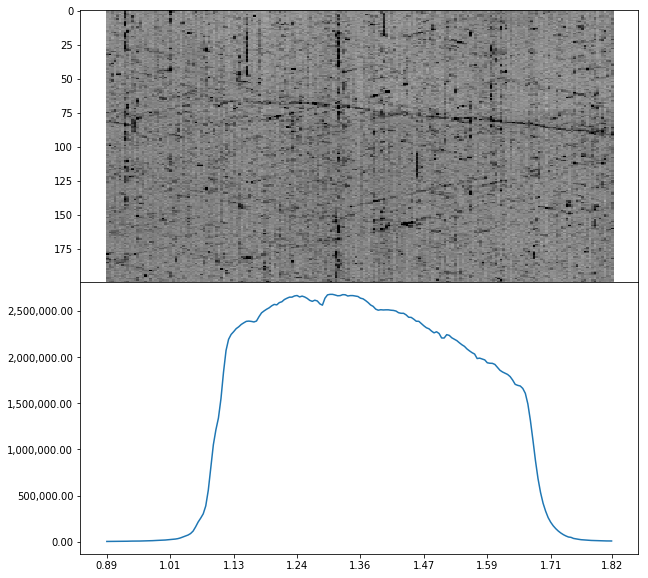

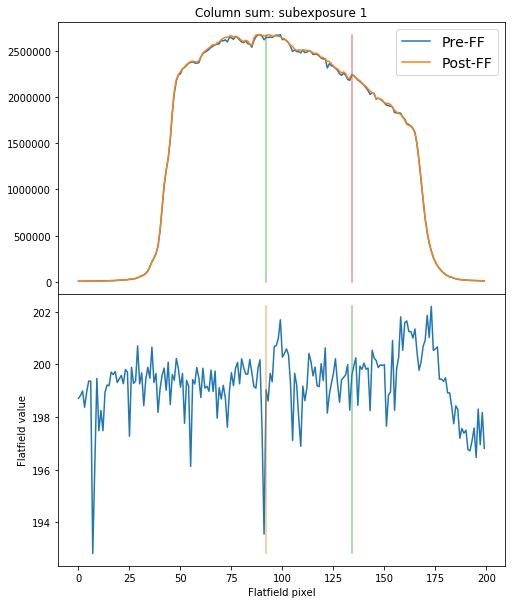

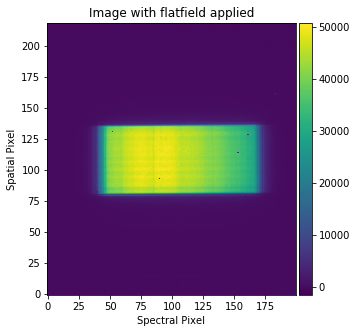

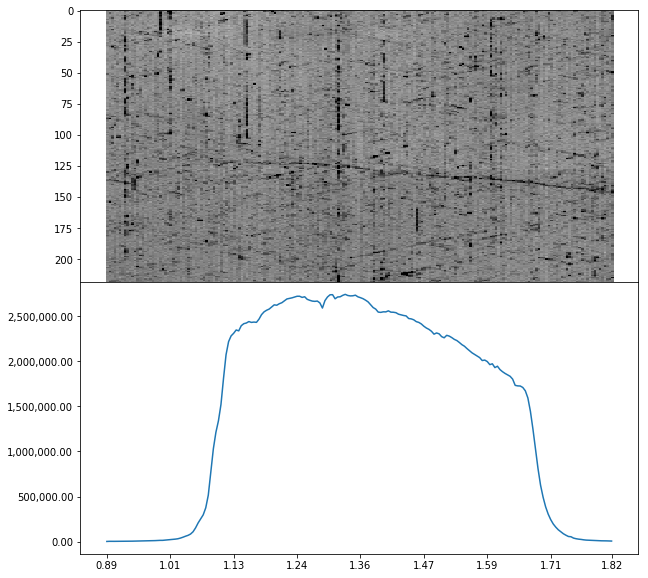

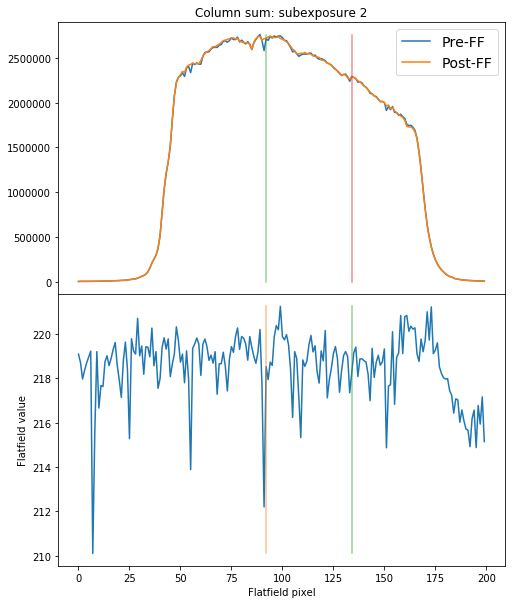

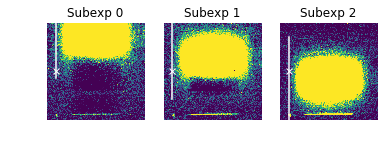

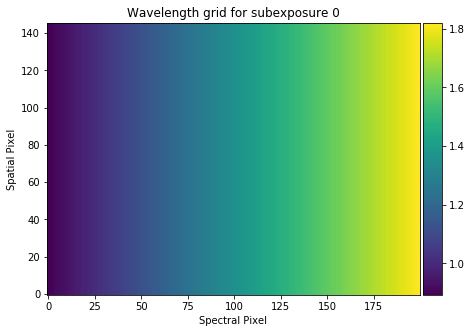

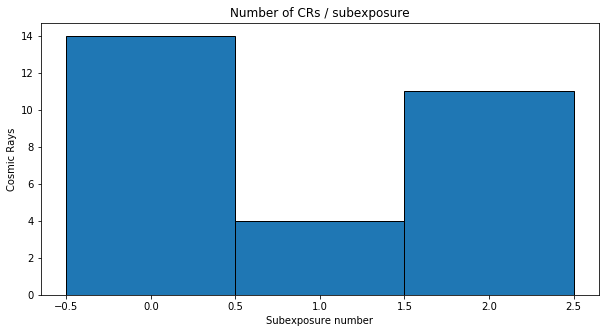

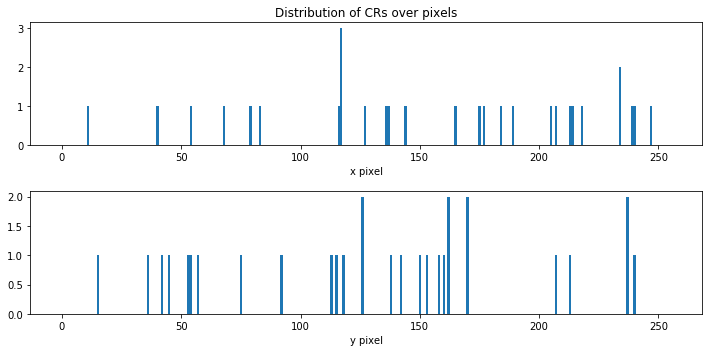

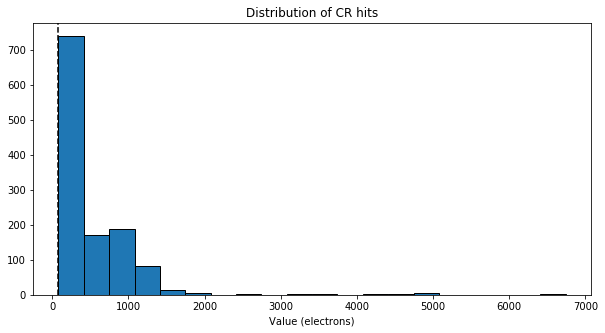

This should have a median energy of 1000 electrons
Nr. of DQs, CRs and CRs minus DQs 2406, 29 and 11
Percentage of pixels affected by CRs:0.0167846679688 %, which should be ~0.0867893833333% if there is no South Atlantic anomaly.


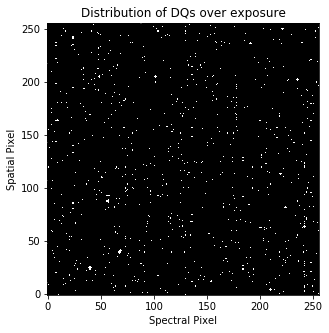

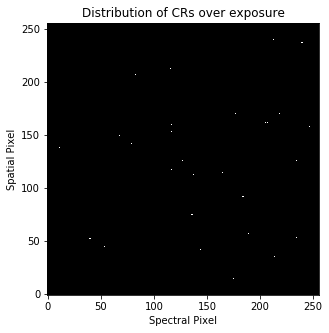

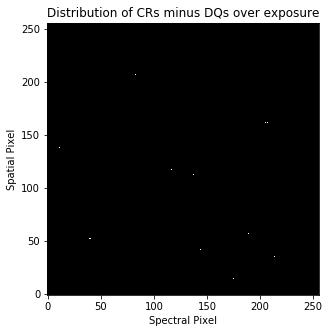

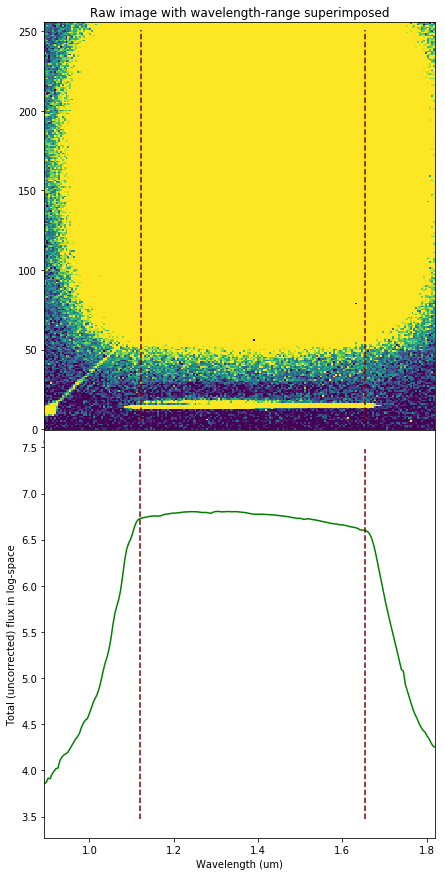

Saving reduced file to /Users/bob/Documents/PhD/HD209458/output/
Saving reduced exposure to /Users/bob/Documents/PhD/HD209458/output/ibh726meq_red.fits...
Reduction took 9.64s
########################################
###########Finished Reduction###########
########################################
########################################
############Started Extraction##########
########################################
Spectral extraction pipeline performed on exposure /Users/bob/Documents/PhD/HD209458/Transmission/ibh726meq_ima.fits
For configuration, see conf file: /Users/bob/Documents/PhD/HD209458/transmission_extraction.conf
Forward scan
Extracting from subexposure 1
Extracting spectrum with a 107 high extraction box
nr. of CRs 810
Spectrum located at pixel 123 in spatial direction
subexp 216.64335974856073 [216, 163, 108]
ypix is 216 for exposure 0


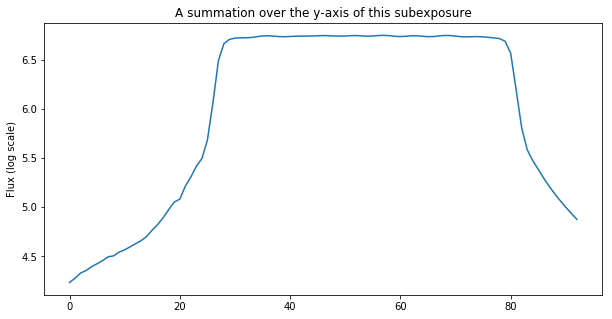

The difference between the two edges (for a 5-pixel bin for all subexps is): 6941.34765625
This value may not be larger than  6298.8743968003255  or else you'll have variations induced by the moving of this subexposure on the y-axis.
Using flux for variance estimate
Extracting spectrum with optimal extraction...
199 successes out of 200 total fits
Optimal extraction fitting failed for columns: [0]
Clipped 0 cosmic rays in OE


<Figure size 720x360 with 0 Axes>

Extracting from subexposure 2
nr. of CRs 814
Spectrum located at pixel 123 in spatial direction
subexp 163.02611334604822 [216, 163, 108]
ypix is 163 for exposure 1


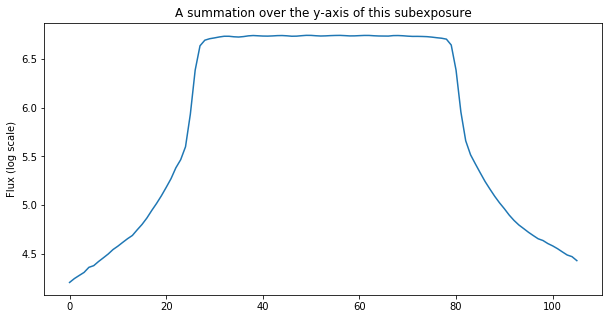

The difference between the two edges (for a 5-pixel bin for all subexps is): 1347.8919921875
This value may not be larger than  6308.240536525748  or else you'll have variations induced by the moving of this subexposure on the y-axis.
Extracting spectrum with optimal extraction...
196 successes out of 200 total fits
Optimal extraction fitting failed for columns: [0, 1, 2, 3]
Clipped 0 cosmic rays in OE


<Figure size 720x360 with 0 Axes>

Extracting from subexposure 3
nr. of CRs 811
Spectrum located at pixel 123 in spatial direction
subexp 108.58583331525763 [216, 163, 108]
ypix is 108 for exposure 2


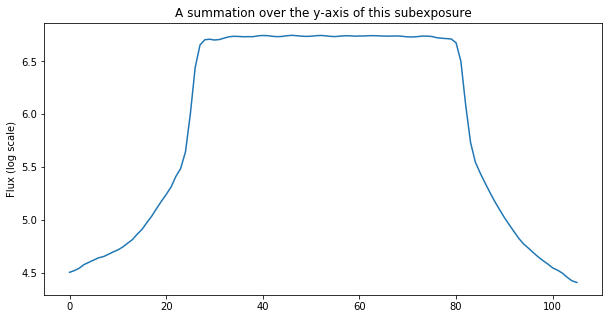

The difference between the two edges (for a 5-pixel bin for all subexps is): 752.464453125
This value may not be larger than  6372.980966549328  or else you'll have variations induced by the moving of this subexposure on the y-axis.
Extracting spectrum with optimal extraction...
191 successes out of 200 total fits
Optimal extraction fitting failed for columns: [7, 8]
Clipped 0 cosmic rays in OE


<Figure size 720x360 with 0 Axes>

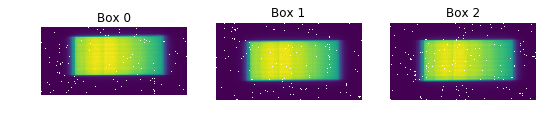

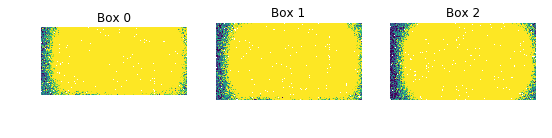

Shifted subexposure nr. 1 with -0.464007622457 pixels and shrunk 0.279534698063 percent.
Shifted subexposure nr. 2 with -0.883999216102 pixels and shrunk 0.546863848286 percent.


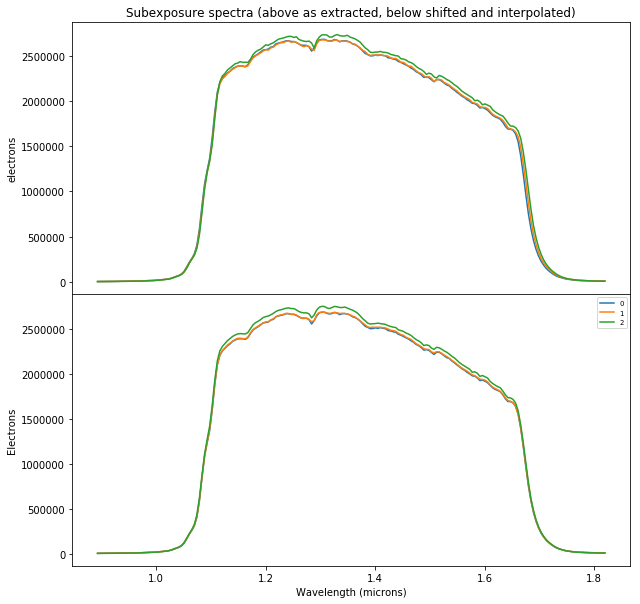

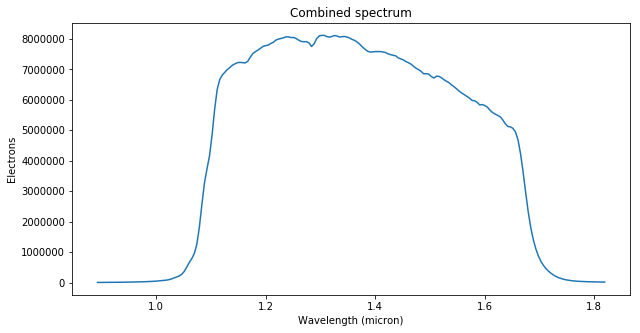

Saving spectrum to /Users/bob/Documents/PhD/HD209458/output/ibh726meq_spec.txt
Saving subexposure spectra to /Users/bob/Documents/PhD/HD209458/output/ibh726meq_subs_spec.txt
Extraction took 1.38s
########################################
###########Finished Extraction##########
########################################


In [26]:
it = 0
for Image in ref_Images:
    visit = 1
    if visit == 1:
        Bg_x, Bg_y, Bg_w, Bg_h = (215, 5, 38, 30)
        Ref_exp = ref_Images[0].split('_ima.fits')[0]
        
    if fname == Ref_exp + '_ima.fits':
        Save_sub = True
    else:
        Save_sub = False
    
    
    exp = pipe.reduce_exposure(Image, pdf=False, logger=False, debug=True,
                           bg_x = Bg_x, bg_y = Bg_y, bg_w = Bg_w, bg_h = Bg_h,
                           ref_exp = Ref_exp,
                           conf_file=conf_file_red, \
                           source_dir=data_dir, write = True)

    if noknots:
        exp_spectrum, variance, interp_spectra, variances = \
                    pipe.extract_spectra(exp, pdf=False, logger=False, debug=True,
                    conf_file=conf_file_ext, ref_exp=Ref_exp,
                    save_dir=output_dir, save_sub=True)
    else:
        exp_spectrum, variance, interp_spectra, variances = \
                    pipe.extract_spectra(exp, pdf=False, logger=False, debug=True,
                    conf_file=conf_file_ext, ref_exp=Ref_exp,
                    custom_knots_F=custom_knots, custom_knots_R=custom_knots[::-1], ypix_F=ypix_F, ypix_R=ypix_R,
                    save_dir=output_dir, save_sub=True)
    

In [27]:
%%capture

BGs0 = []
BGs2 = []
Ts  = []
reload(pipe)
it = 0
for Image in Images:
    visit = 1
    if visit == 1:
        Bg_x, Bg_y, Bg_w, Bg_h = (215, 5, 38, 30)
        Ref_exp = ref_Images[0].split('_ima.fits')[0]
    if Image == Ref_exp + '_ima.fits':
        Save_sub = True
    else:
        Save_sub = False
    
    
    exp = pipe.reduce_exposure(Image, pdf=False, logger=False, debug=False,
                           skip_start=1,
                           bg_x = Bg_x, bg_y = Bg_y, bg_w = Bg_w, bg_h = Bg_h,
                           ref_exp = Ref_exp,
                           conf_file=conf_file_red, \
                           source_dir=data_dir, write = True)

    if noknots:
        exp_spectrum, variance, interp_spectra, variances = \
                    pipe.extract_spectra(exp, pdf=False, logger=False, debug=True,
                    conf_file=conf_file_ext, ref_exp=Ref_exp,
                    save_dir=output_dir, save_sub=Save_sub)
    else:
        exp_spectrum, variance, interp_spectra, variances = \
                    pipe.extract_spectra(exp, pdf=False, logger=False, debug=False,
                    conf_file=conf_file_ext, ref_exp=Ref_exp, ypix_F=ypix_F, ypix_R=ypix_R,
                    custom_knots_F=custom_knots, custom_knots_R=custom_knots[::-1],
                    save_dir=output_dir, save_sub=Save_sub)
    
    BGs0.append(exp.BGs[0][0,0])
    BGs2.append(exp.BGs[2][0,0])
    Ts.append(exp.t)
    it +=1
    

Text(0,0.5,'Pixel value')

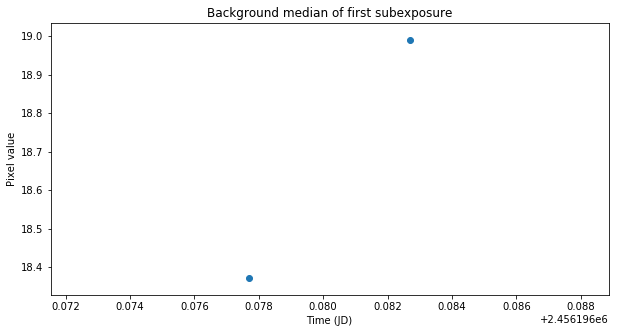

In [12]:
plt.title('Background median of first subexposure')
plt.scatter(Ts, BGs0)
plt.xlabel('Time (JD)')
plt.ylabel('Pixel value')

Text(0,0.5,'Pixel value')

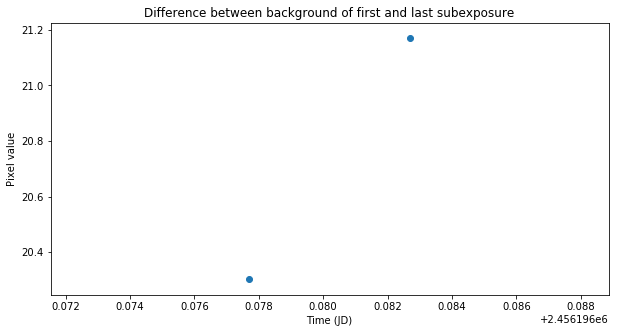

In [13]:
plt.scatter(Ts, np.array(BGs2) - np.array(BGs0))
plt.title('Difference between background of first and last subexposure')
plt.xlabel('Time (JD)')
plt.ylabel('Pixel value')